## MESA lab: An exploration in agent-based models using forest fire simulation

The Python package MESA aids in the modeling, analysis, and visualization of agent-based data, making it a perfect candidate for use in modeling forest fires. 

An agent based model requires agents as well as an environment for the agents to interact with. Here, we'll define trees as agents, and disperse them into a grid with a user-defined density. 

Wind is one of the largest influences on forest fire spread. In Tom Beer's study, *the Interaction of Wind and Fire* http://link.springer.com/article/10.1007%2FBF00183958 he explains how and why fire spreads so much faster during unstable wind conditions. We use the windspeeds in his work to impose conditions for fire spread on the agents. This is done using MESA's Moore neighborhood argument, a boolean that identifies the eight neighbors around a cell. 

Import the necessary modules: 

In [149]:
import random
from numpy.random import uniform
from numpy import multiply
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import Grid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner
from numpy import multiply
from scipy.ndimage.filters import gaussian_filter

import pandas as pd
import matplotlib.cm as cm
from math import pi

Define the agents (trees). Give them a position in the grid, and using an if/else statement, say whether or not their neighbors will catch fire if they are on fire. -Again, this requires the Moore's neighborhood argument, as well as a defined range of windspeeds and radius of fire spread.  

In [151]:
class TreeCell(Agent):
    '''
    A tree cell.
    
    Attributes:
        x, y: Grid coordinates
        condition: Can be "Fine", "On Fire", or "Burned Out"
        unique_id: (x,y) tuple. 
    
    unique_id isn't strictly necessary here, but it's good practice to give one to each
    agent anyway.
    '''
    def __init__(self, model, pos):
        '''
        Create a new tree.
        Args:
            pos: The tree's coordinates on the grid. Used as the unique_id
        '''
        super().__init__(pos, model)
        self.pos = pos
        self.unique_id = pos
        self.condition = "Fine"
        
    def step(self):
        '''
        If windspeed is under 2, only immediate neighbors with a common edge catch fire.
        If windspeed is between 2 and 6, all neighbors in Moore's neighborhood catch fire.
        If windspeed is 6 or greater, Moore's neighbors within a radius of 2 squares catch fire.
        '''
        if self.condition == "On Fire":
            if 2 <= self.model.wind < 6: 
                neighbors = self.model.grid.get_neighbors(self.pos, moore = True)
            elif self.model.wind >= 6:
                neighbors = self.model.grid.get_neighbors(self.pos, radius = 2, moore = True)
            else:
                neighbors = self.model.grid.get_neighbors(self.pos, moore = False)
            for neighbor in neighbors:
                if neighbor.condition == "Fine":
                    neighbor.condition = "On Fire"
            self.condition = "Burned Out"

In [136]:
class ForestFire(Model):
    '''
    Simple Forest Fire model.
    '''
    def __init__(self, height, width, density, wind):
        '''
        Create a new forest fire model.
        
        Args:
            height, width: The size of the grid to model
            density: What fraction of grid cells have a tree in them.
        '''
        # Initialize model parameters
        self.height = height
        self.width = width
        self.density = density
        self.wind = wind
        
        # Set up model objects
        self.schedule = RandomActivation(self)
        self.grid = Grid(height, width, torus=False)
        self.dc = DataCollector({"Fine": lambda m: self.count_type(m, "Fine"),
                                "On Fire": lambda m: self.count_type(m, "On Fire"),
                                "Burned Out": lambda m: self.count_type(m, "Burned Out")})
        
        # Place a tree in each cell with Prob = density
        for x in range(self.width):
            for y in range(self.height):
                if random.random() < self.density:
                    # Create a tree
                    new_tree = TreeCell(self, (x, y))
                    # Set all trees in the first column on fire.
                    if x == 0:
                        new_tree.condition = "On Fire"
                    self.grid[x][y] = new_tree
                    self.schedule.add(new_tree)
        self.running = True
        
    def step(self):
        '''
        Advance the model by one step.
        '''
        self.schedule.step()
        self.dc.collect(self)
        # Halt if no more fire
        if self.count_type(self, "On Fire") == 0:
            self.running = False
            
    @staticmethod
    def count_type(model, tree_condition):
        '''
        Helper method to count trees in a given condition in a given model.
        '''
        count = 0
        for tree in model.schedule.agents:
            if tree.condition == tree_condition:
                count += 1
        return count


In [137]:
fire = ForestFire(200, 200, 0.4, 3)
fire.run_model()

In [138]:
results = fire.dc.get_model_vars_dataframe()
results['Burn Fraction'] = (results['Burned Out']/(results['Burned Out']+results['Fine']+results['On Fire']))
results.head()

,Burned Out,Fine,On Fire,Burn Fraction
0,120,15767,60,0.007525
1,216,15685,46,0.013545
2,327,15570,50,0.020505
3,409,15484,54,0.025647
4,508,15384,55,0.031856


In [139]:
results.tail()

,Burned Out,Fine,On Fire,Burn Fraction
87,6410,9531,6,0.401956
88,6427,9512,8,0.403023
89,6438,9506,3,0.403712
90,6442,9503,2,0.403963
91,6444,9503,0,0.404089


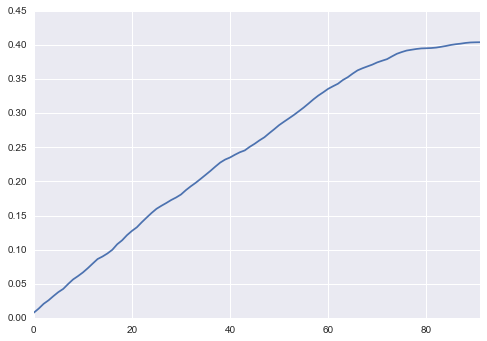

In [140]:
burn = results['Burn Fraction'].plot()

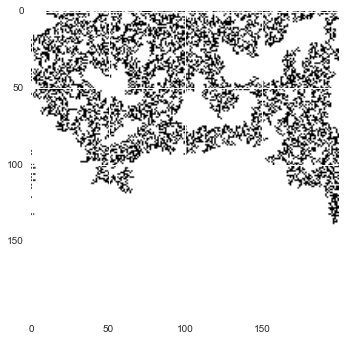

In [141]:
treeCounts = np.zeros((fire.grid.width, fire.grid.height))
for cell in fire.grid.coord_iter():
    cell_content, x, y = cell
    try:
        if cell[0].condition == "Burned Out":
            treeCount = 1
    except:
        treeCount = 0
    treeCounts[x][y] = treeCount
trees = plt.imshow(treeCounts)

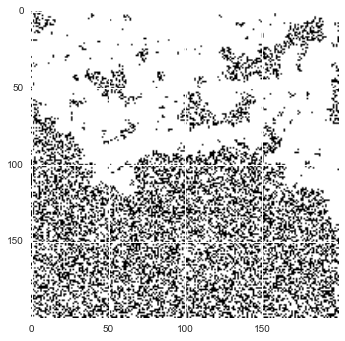

In [142]:
treeCounts = np.zeros((fire.grid.width, fire.grid.height))
for cell in fire.grid.coord_iter():
    cell_content, x, y = cell
    try:
        if cell[0].condition == "Fine":
            treeCount = 1
    except:
        treeCount = 0
    treeCounts[x][y] = treeCount
trees = plt.imshow(treeCounts)

In [143]:
fire = ForestFire(200, 200, 0.4, 6)
fire.run_model()

In [147]:
results = fire.dc.get_model_vars_dataframe()
results['Burn Fraction'] = (results['Burned Out']/(results['Burned Out']+results['Fine']+results['On Fire']))

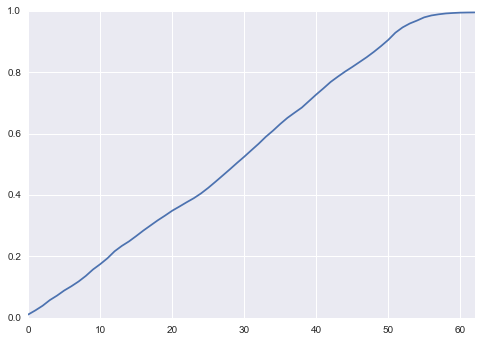

In [148]:
burn = results['Burn Fraction'].plot()

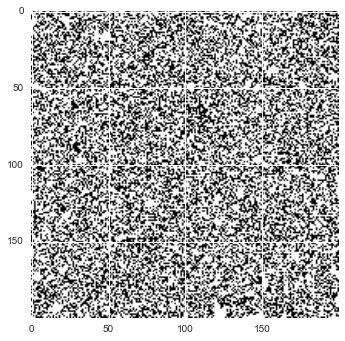

In [145]:
treeCounts = np.zeros((fire.grid.width, fire.grid.height))
for cell in fire.grid.coord_iter():
    cell_content, x, y = cell
    try:
        if cell[0].condition == "Burned Out":
            treeCount = 1
    except:
        treeCount = 0
    treeCounts[x][y] = treeCount
trees = plt.imshow(treeCounts)

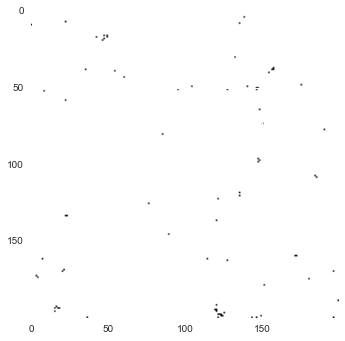

In [144]:
treeCounts = np.zeros((fire.grid.width, fire.grid.height))
for cell in fire.grid.coord_iter():
    cell_content, x, y = cell
    try:
        if cell[0].condition == "Fine":
            treeCount = 1
    except:
        treeCount = 0
    treeCounts[x][y] = treeCount
trees = plt.imshow(treeCounts)